**Introduction**

This is an example pipeline to show you how to create a VDB volume out of MRI data. We are using [nibabel](https://nipy.org/nibabel/) and [pyopenvdb](https://academysoftwarefoundation.github.io/openvdb/python/index.html) (click links for documents). The virtual environment is run with poetry

In [2]:
import os
import nibabel as nib
import pylab as plt
import numpy as np
from functions import *
from classes import *

In [3]:
proj_root = parent_directory()
print(proj_root)
input_filepath = os.path.join(proj_root, "media/sub-01/anat/sub-01_T2w.nii.gz")
output_folder = os.path.join(proj_root, "output/")
fmri = MRI_Anat(input_filepath)

/Users/joachimpfefferkorn/repos/neurovolume


**Data From the Scanner**

Observe below how flattened the data is. We will need to fix that with an affine (more below)

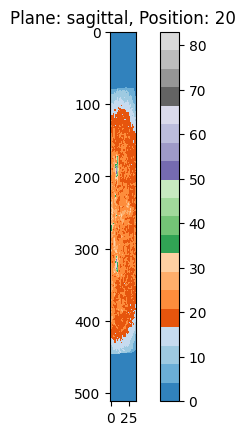

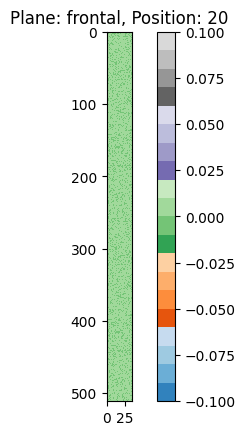

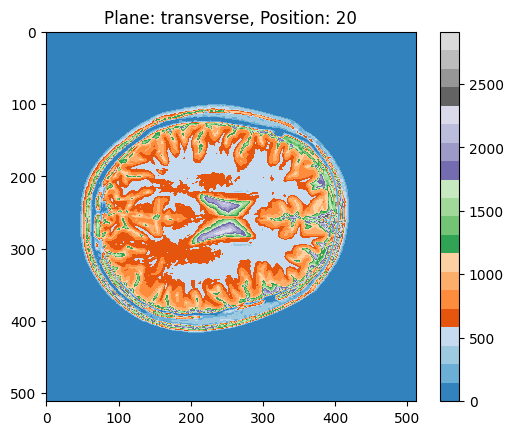

In [4]:
fmri.view_slice(plane="sagittal")
fmri.view_slice(plane="frontal")
fmri.view_slice(plane="transverse")

**Affine Transforms**

[relevant NiBabel Documentation](https://nipy.org/nibabel/coordinate_systems.html)
As we can see from the above work and visualizations, our volume does not account for $z$ depth. We need to use the affine to transform this voxel data into an anatomically accurate volume.

Let's call this new volume `anat_vol`. It will hold an anatomically accurate volume of each voxel corresponding a specific part of the brain as it existed in the scanner. As per NiBabel specifications, will be in $RAS+$ space, meaning $Right$, $Anterior$, $Superior$, are all positive values along these ordered axis. This 

*Mild Extrapolation*: the raw voxel data seems to iterate each slice by just one integer, thus encoding order but not exact position. This particular scan seems to have taken slices down the saggital ($z$) plane. Thus the brain appears to be vertically squashed down. The affine stored in this header will "inflate" the brain to it's anatomically accurate, real-life, geometry

The $4 \times 4$ image $affine$ array stored in `brain_img.affine` can be used to get this accurate geometry.
This affine includes the following:
- Combined zoom and rotation matrices (seen here in the $m_{\:row,\: column}$)
- Translation units $a$, $b$, and $c$
- An additional row of $[0,0,0,1]$ to create homogenous coordinates (allows us to have both translation, rotation, and zooms in the same matrix)

$$\begin{bmatrix}
m_{1,1} & m_{1,2} & m_{1,3} & a\\
m_{2,1} & m_{2,2} & m_{2,3} & b \\
m_{3,1} & m_{3,2} & m_{3,3} & c \\
0 & 0 & 0 & 1
\end{bmatrix}$$


In [5]:
print(f"Affine:\n{fmri.brain_img.affine}\n")
zoom_rotation = fmri.brain_img.affine[:3, :3]
transform = fmri.brain_img.affine[:3, 3:]
print(f"Zoom and Rotation (M):\n{zoom_rotation}\Translation (a,b,c):\n{transform}")

Affine:
[[  -0.5           0.           -0.          129.70300293]
 [  -0.            0.5          -0.         -110.68299866]
 [   0.            0.            4.          -74.83930206]
 [   0.            0.            0.            1.        ]]

Zoom and Rotation (M):
[[-0.5  0.  -0. ]
 [-0.   0.5 -0. ]
 [ 0.   0.   4. ]]\Translation (a,b,c):
[[ 129.70300293]
 [-110.68299866]
 [ -74.83930206]]


For convenience sake, we usually break the affine matrix into it's components $M$ and $(a,b,c)$. (Otherwise we would have to add an additional 1 to our input and output coordinates).
In the following equation:
- $x,y,z$ are our output `anat_vol` voxel coordinates
- $M$ is our combined zoom and rotation matrices
- $i,j,k$ are our raw input voxels coordinates
- $a,b,c$ make up our translation offset coordinates


$$\begin{bmatrix} x\\ y \\ z \end{bmatrix} = M \begin{bmatrix} i\\ j \\ k \end{bmatrix} + \begin{bmatrix} a\\ b \\ c \end{bmatrix}$$

**Quick Linear Algebra and Tensor Brushup**
Had a very clarifying talk with Camille at RC

Each voxel (as viewed in the `matplotlib` above) has a certain $value$, which is it's density. It also has a certain position, which is an $x,y,z$ coordinate.

Let's think of the MRI as a list of $4D$ arrays, each one carries the coordinates and position above. Each array will look something like $$[x,y,z,value]$$

In order to transform this volume, we need to apply the affine to each one of these $x,y,z$ coordinates while leaving the $value$ unchanged.

Luckily for us, we are just going to let `openvdb` do all that work. However we will need to modify hte affine slightly (more below)

In [6]:
affine_as_list = fmri.brain_img.affine.tolist()
print(affine_as_list)

[[-0.5, 0.0, -0.0, 129.7030029296875], [-0.0, 0.5, -0.0, -110.68299865722656], [0.0, 0.0, 4.0, -74.83930206298828], [0.0, 0.0, 0.0, 1.0]]


We also need to normalize the volume

In [7]:
# Still need this weird function. This does work
normalized_brain_tensor = np.array(normalize_array(fmri.brain_data))
vol = create_volume(normalized_brain_tensor)

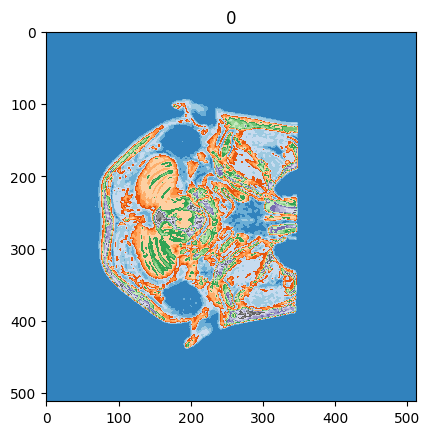

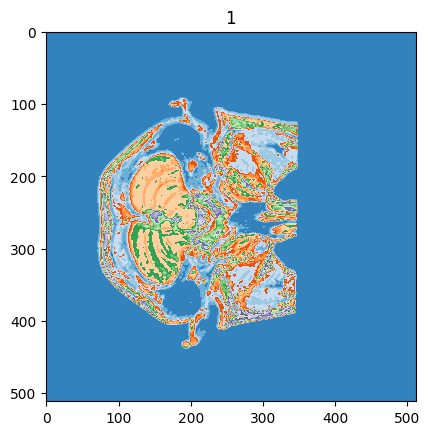

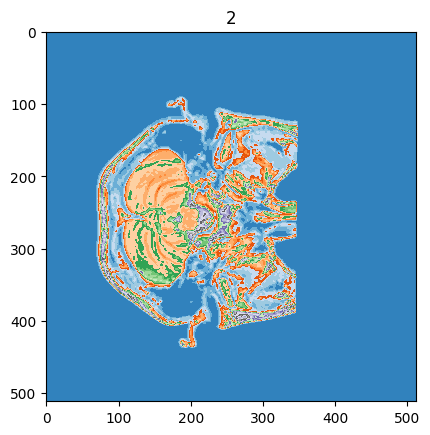

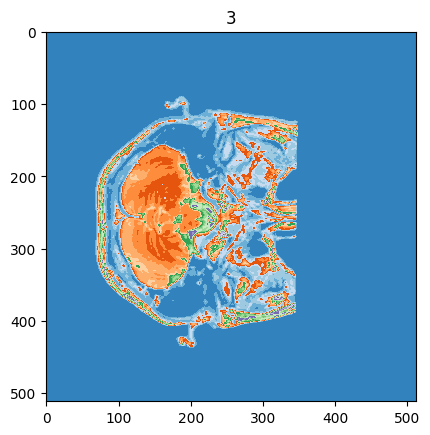

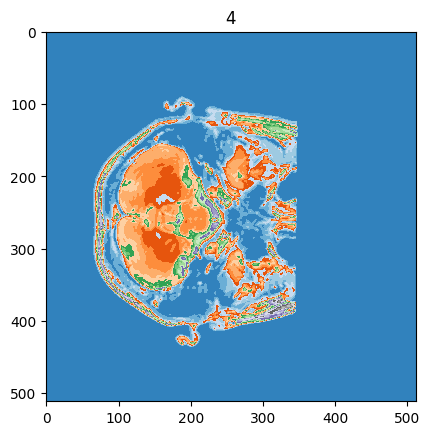

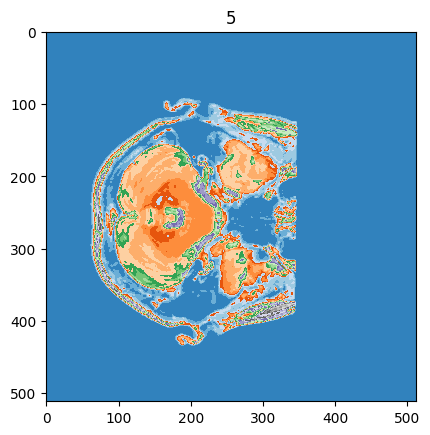

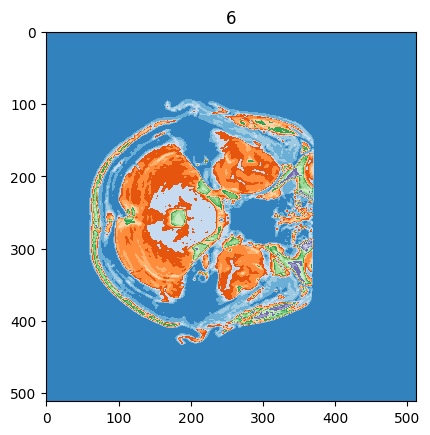

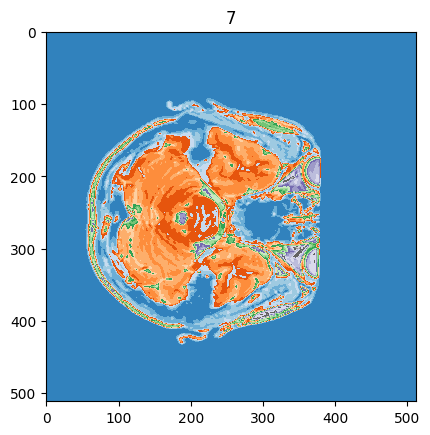

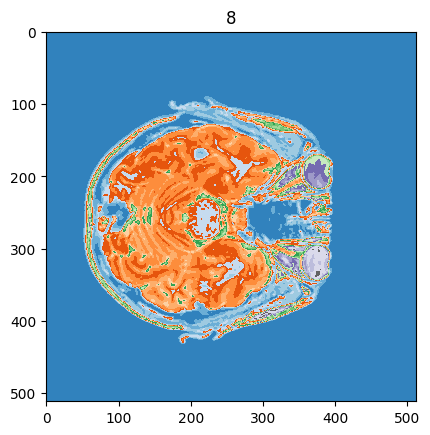

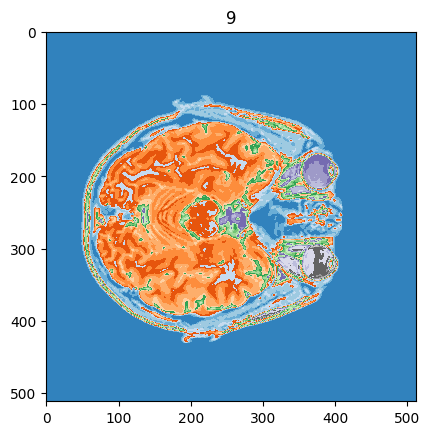

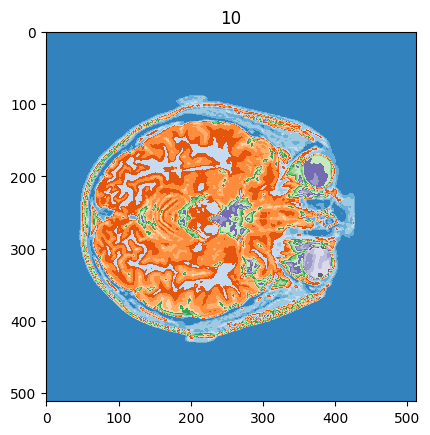

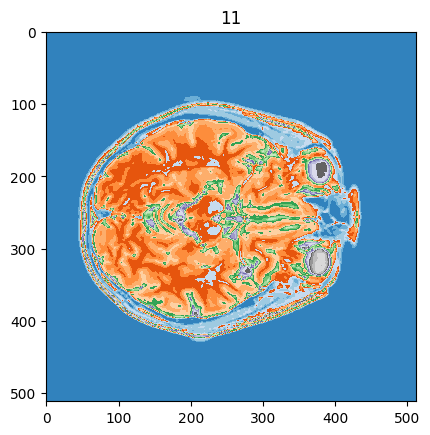

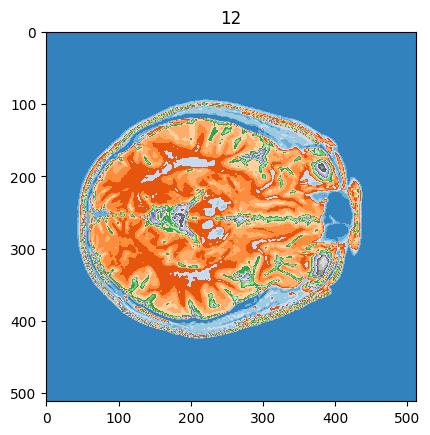

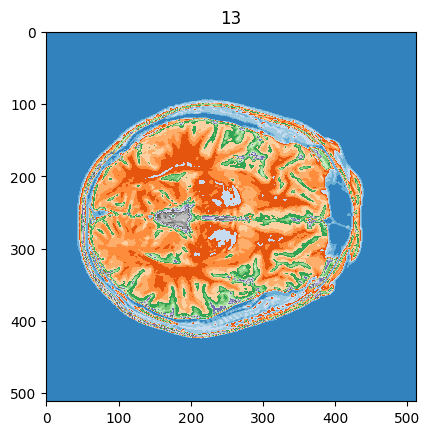

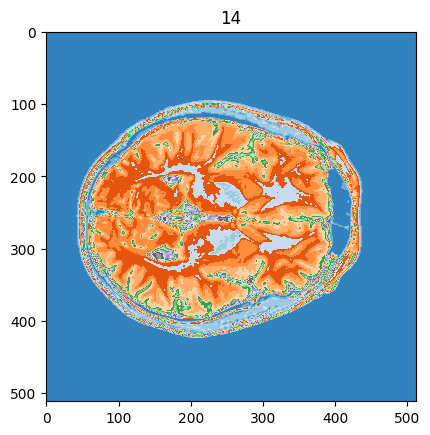

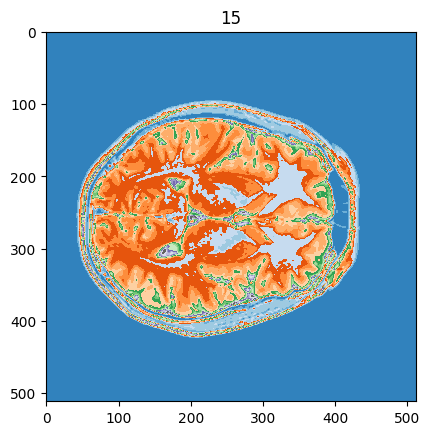

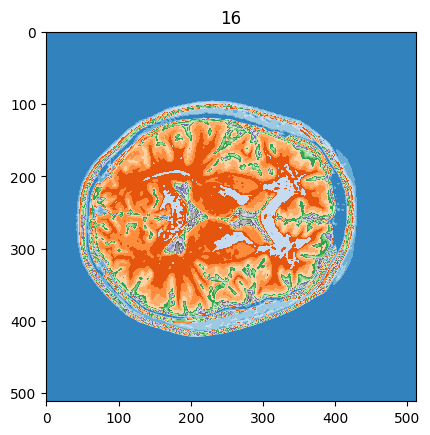

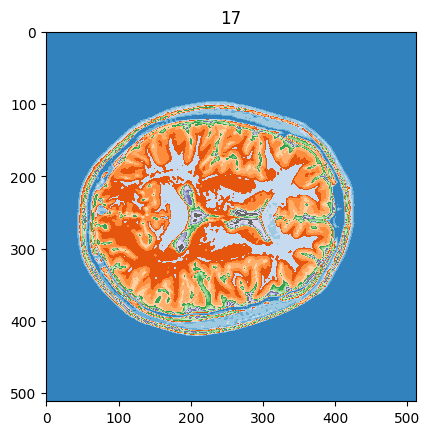

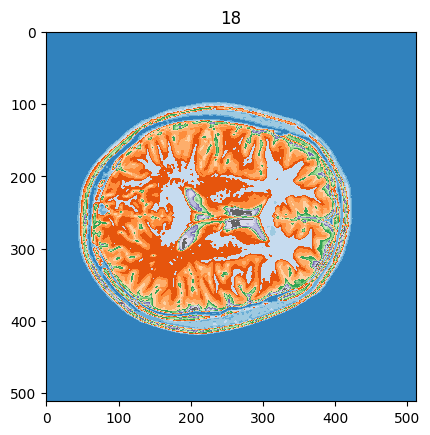

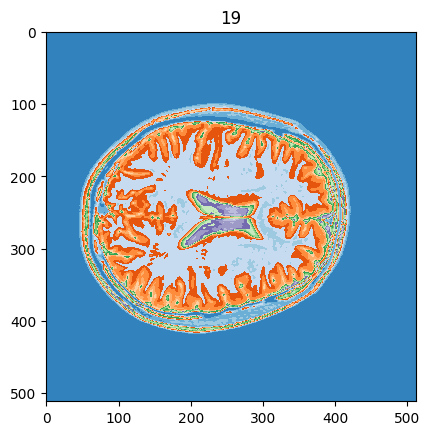

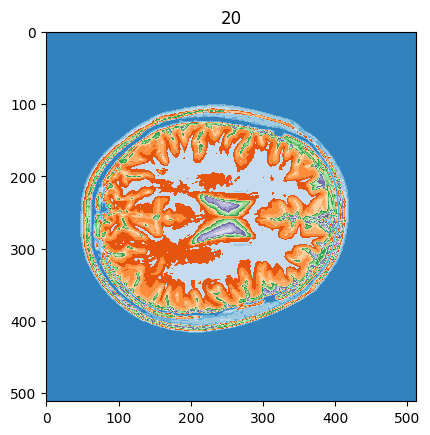

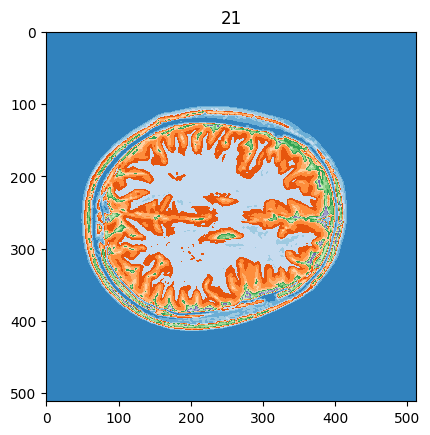

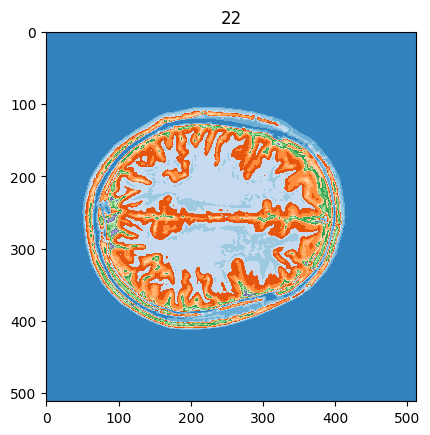

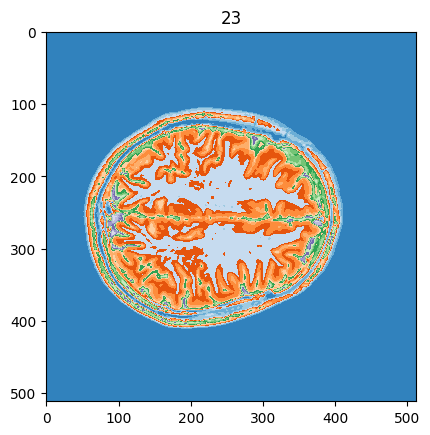

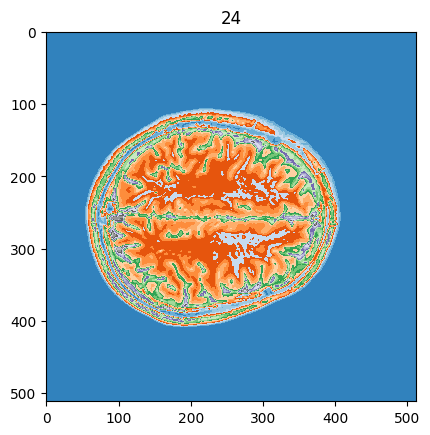

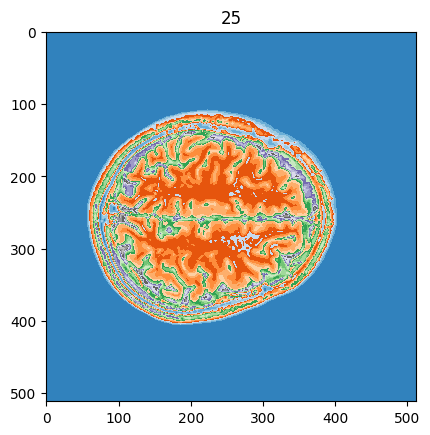

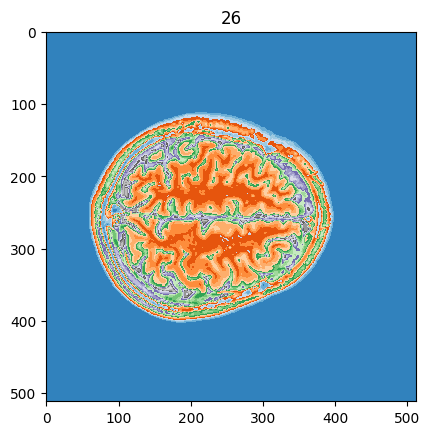

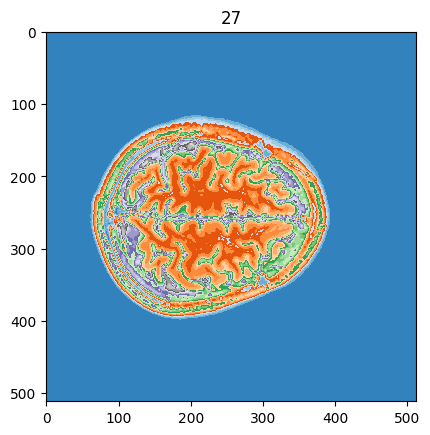

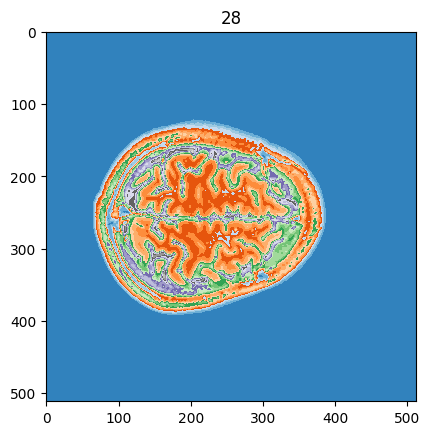

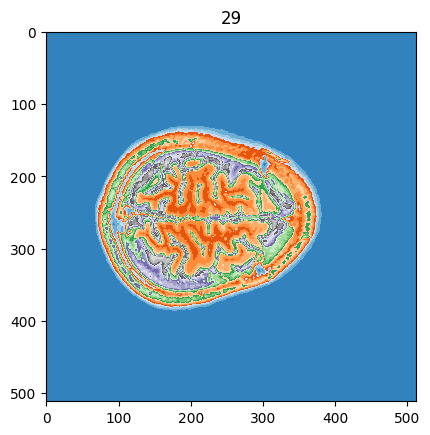

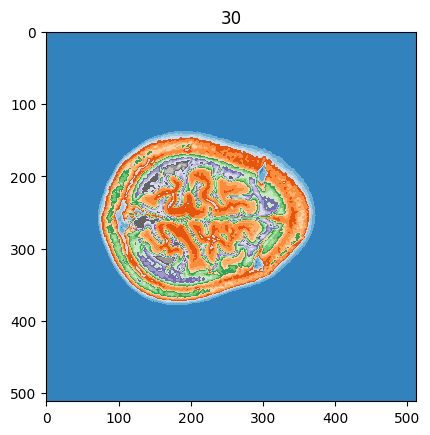

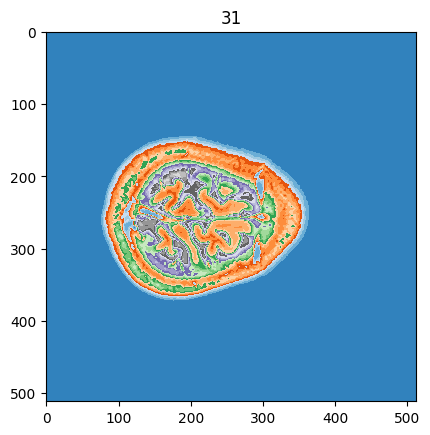

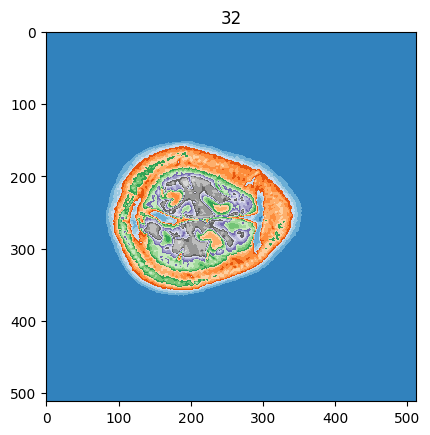

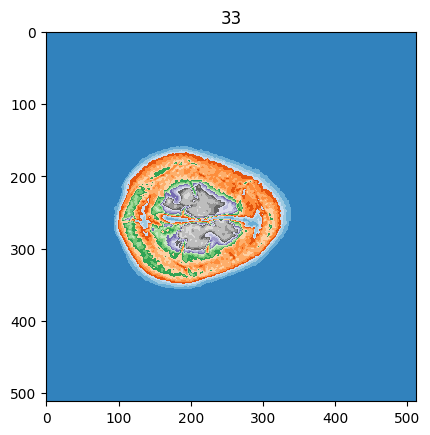

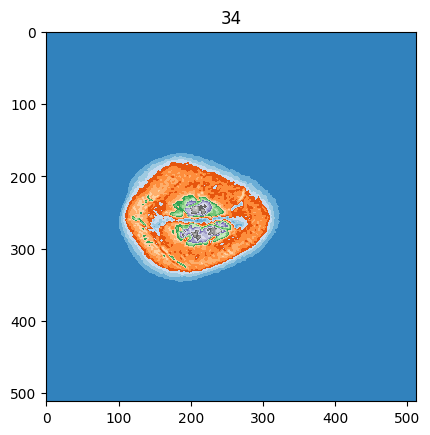

In [12]:
#quick debug as this turns up blank in blender
#view_sagittal_slice(vol, 20, "tab20c")
view_all_sagittal_slices(vol, "tab20c")

In [16]:
np.save("{}/anatomy.npy".format(output_folder), vol)

**Linear Transformations in OpenVDB**
As per the [documentation](https://academysoftwarefoundation.github.io/openvdb/python/pyopenvdb-module.html#createLinearTransform), OpenVDB appears to treat linear transformations similarly to the nibabel affine transformations:

>Create a new linear transform from a 4 x 4 matrix given as a sequence of the form [[a, b, c, d], [e, f, g, h], [i, j, k, l], [m, n, o, p]], where [m, n, o, p] is the translation component.

While not wonderfully documented, I am guessing that this is simply a transposed version of the affine wtih $d$,$h$, $l$ equal to $0$ and $p=1$.

Let's see if we can build this

In [14]:
affine = fmri.brain_img.affine
vdb_transform = affine.transpose()
print(affine, "\n")
print(vdb_transform)

[[  -0.5           0.           -0.          129.70300293]
 [  -0.            0.5          -0.         -110.68299866]
 [   0.            0.            4.          -74.83930206]
 [   0.            0.            0.            1.        ]] 

[[  -0.5          -0.            0.            0.        ]
 [   0.            0.5           0.            0.        ]
 [  -0.           -0.            4.            0.        ]
 [ 129.70300293 -110.68299866  -74.83930206    1.        ]]


In [21]:
print(vdb_transform[3][0])

129.7030029296875


In [15]:
np.save("{}/affine.npy".format(output_folder), vdb_transform.tolist())

Good news: this is read in as a valid affine!

Bad news: the volume appears to be empty